<a href="https://colab.research.google.com/github/massimocipressi/MLPNS_MCipressi/blob/main/PINN/PINN_Burgers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
import numpy as np
tf.__version__

'2.12.0'

In [ ]:
import scipy
from scipy import io
from scipy.interpolate import griddata
import pylab as pl

In [ ]:
!wget https://github.com/maziarraissi/PINNs/raw/master/appendix/Data/burgers_shock.mat

--2023-04-28 11:00:07--  https://github.com/maziarraissi/PINNs/raw/master/appendix/Data/burgers_shock.mat
Resolving github.com (github.com)... 140.82.114.4
Connecting to github.com (github.com)|140.82.114.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/maziarraissi/PINNs/master/appendix/Data/burgers_shock.mat [following]
--2023-04-28 11:00:07--  https://raw.githubusercontent.com/maziarraissi/PINNs/master/appendix/Data/burgers_shock.mat
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 207944 (203K) [application/octet-stream]
Saving to: ‘burgers_shock.mat’

burgers_shock.mat   100%[===================>] 203.07K  --.-KB/s    in 0.02s   

2023-04-28 11:00:07 (8.38 MB/s) - ‘burgers_shock.mat’ saved

(100,) (256,) (256, 100)


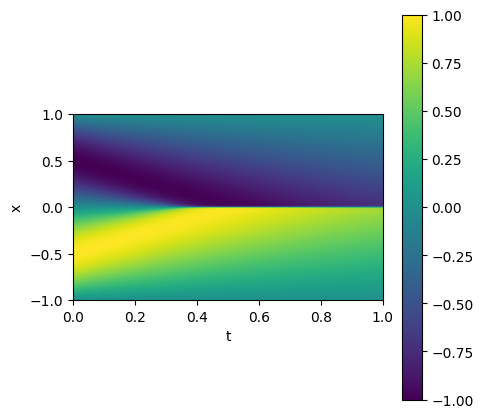

In [ ]:
### what is the solution that we want? read in the data


data = scipy.io.loadmat('burgers_shock.mat')
    
data.keys()

t = data['t'].flatten()
x = data['x'].flatten()
Z = np.real(data['usol'])

print(t.shape, x.shape, Z.shape)

ax = pl.figure(figsize=(5,5)).add_subplot(111)
cb = ax.imshow(Z[::-1],extent=[0,1,-1,1], clim=(-1,1))
ax.set_xlabel("t")
ax.set_ylabel("x");
ax.set_aspect(0.3)
pl.colorbar(cb);


# PROBLEM SETUP: BURGER'S EQUATIONS
$$
\begin{align}
    \partial_t u (t,x) + \mathcal{N}[u](t,x) &= 0, && (t,x) \in (0,T] \times \mathcal{D},\\
    u(0,x) &= u_0(x) \quad && x \in \mathcal{D},
\end{align}
$$


$$
\begin{align}
        \hspace{7em} u(t,x) &= u_b(t,x)  && \quad (t,x) \in (0,T] \times \partial \mathcal{D},
\end{align}
$$


# SPECIFIC CASE: LIMIT REGIME AND SET VISCOSITY TO $\nu=0.01/\pi$

$$
\begin{aligned}
    \partial_t u + u \, \partial_x u - (0.01/\pi) \, \partial_{xx} u &= 0, \quad &&\quad (t,x) \in (0,1] \times (-1,1),\\
   u(0,x) &= - \sin(\pi \, x),                 \quad &&\quad x \in [-1,1],\\
   u(t,-1) = u(t,1) &= 0,                      \quad &&\quad t \in (0,1].
\end{aligned}
$$

In [ ]:
tf.random.set_seed(123)
pi = tf.constant(np.pi, dtype="float32")

In [ ]:
def fun_u_0(x):
  return -tf.sin(pi * x)

def fun_u_b(t, x):
  return tf.zeros((x.shape[0], 1), dtype="float32")

def fun_res(u, u_t, u_x, u_xx):
  return tf.abs(u_t + u * u_x - 0.01 / pi * u_xx)

In [ ]:
#number of points we are using for training and predicting
n_b = 50
n_0 = 50
n_r = 10000

#boundaries
tmin = 0.
tmax = 1.
xmin = -1.
xmax = 1.

# get random data in x at t=0


In [ ]:
t_0 = tf.ones((n_0, 1), dtype="float32") * tmin
x_0 = tf.random.uniform((n_0, 1), xmin, xmax, dtype="float32")
X_0 = tf.concat([t_0, x_0], axis=1)
X_0

<tf.Tensor: shape=(50, 2), dtype=float32, numpy=
array([[ 0.        , -0.7476938 ],
       [ 0.        ,  0.14550257],
       [ 0.        , -0.4013734 ],
       [ 0.        ,  0.09236717],
       [ 0.        ,  0.44103146],
       [ 0.        ,  0.5779066 ],
       [ 0.        , -0.3846376 ],
       [ 0.        , -0.03657794],
       [ 0.        ,  0.30755043],
       [ 0.        , -0.7580149 ],
       [ 0.        , -0.27416515],
       [ 0.        , -0.5102    ],
       [ 0.        , -0.54608774],
       [ 0.        ,  0.04020071],
       [ 0.        ,  0.7369325 ],
       [ 0.        , -0.42762113],
       [ 0.        , -0.01630592],
       [ 0.        ,  0.34997678],
       [ 0.        , -0.11965895],
       [ 0.        , -0.02140164],
       [ 0.        ,  0.6112704 ],
       [ 0.        ,  0.7948568 ],
       [ 0.        ,  0.27323198],
       [ 0.        ,  0.00240111],
       [ 0.        , -0.03221846],
       [ 0.        ,  0.50451255],
       [ 0.        ,  0.6129718 ],
      

# evaluate initial condition at x_0

In [ ]:
u_0 = fun_u_0(x_0)
u_0

<tf.Tensor: shape=(50, 1), dtype=float32, numpy=
array([[ 0.7122112 ],
       [-0.44135648],
       [ 0.95238096],
       [-0.28612474],
       [-0.9828893 ],
       [-0.97019774],
       [ 0.93504095],
       [ 0.11466026],
       [-0.8227306 ],
       [ 0.6890799 ],
       [ 0.7587001 ],
       [ 0.9994866 ],
       [ 0.9895364 ],
       [-0.12595879],
       [-0.7355314 ],
       [ 0.97425926],
       [ 0.05120417],
       [-0.89097345],
       [ 0.36712813],
       [ 0.0671846 ],
       [-0.9395213 ],
       [-0.60077995],
       [-0.756787  ],
       [-0.00754325],
       [ 0.10104453],
       [-0.9998995 ],
       [-0.9376773 ],
       [ 0.06082507],
       [ 0.49481562],
       [-0.48312566],
       [ 0.94241977],
       [-0.5245297 ],
       [-0.8038826 ],
       [ 0.8135314 ],
       [-0.8391674 ],
       [-0.85155034],
       [-0.9423501 ],
       [ 0.77795136],
       [ 0.5914944 ],
       [ 0.09085801],
       [ 0.49529788],
       [ 0.4755419 ],
       [ 0.01998235],
     

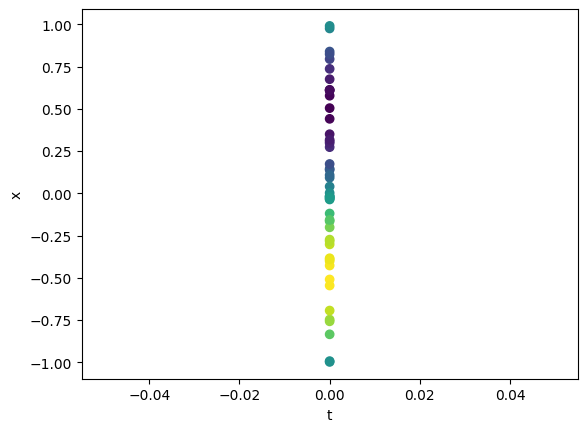

In [ ]:
pl.scatter(t_0, x_0, c=u_0, marker='o', clim=(-1,1))
pl.xlabel("t")
pl.ylabel("x");

# get data at boundaries of x at random t's



In [ ]:
t_b = tf.random.uniform((n_b, 1), tmin, tmax, dtype="float32")
x_b = xmin + (xmax - xmin) * tf.keras.backend.random_bernoulli((n_b, 1), 0.5, dtype="float32")
X_b = tf.concat([t_b, x_b], axis=1)
X_b

<tf.Tensor: shape=(50, 2), dtype=float32, numpy=
array([[ 0.88968754,  1.        ],
       [ 0.12354946,  1.        ],
       [ 0.7718717 , -1.        ],
       [ 0.6850728 , -1.        ],
       [ 0.6442598 ,  1.        ],
       [ 0.07745004,  1.        ],
       [ 0.75058556, -1.        ],
       [ 0.6250843 ,  1.        ],
       [ 0.00772953, -1.        ],
       [ 0.55370283,  1.        ],
       [ 0.83894694, -1.        ],
       [ 0.43658102, -1.        ],
       [ 0.9566101 ,  1.        ],
       [ 0.7588576 ,  1.        ],
       [ 0.8964343 ,  1.        ],
       [ 0.44467843, -1.        ],
       [ 0.3243779 ,  1.        ],
       [ 0.3443855 ,  1.        ],
       [ 0.91262174,  1.        ],
       [ 0.77731085, -1.        ],
       [ 0.899588  ,  1.        ],
       [ 0.50426483, -1.        ],
       [ 0.45032525, -1.        ],
       [ 0.5939442 ,  1.        ],
       [ 0.71862614, -1.        ],
       [ 0.91657436,  1.        ],
       [ 0.98180914, -1.        ],
      

# evaluate data at boundaries of x at random t's


In [ ]:
u_b = fun_u_b(t_b, x_b)
u_b

<tf.Tensor: shape=(50, 1), dtype=float32, numpy=
array([[0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.]], dtype=float32)>

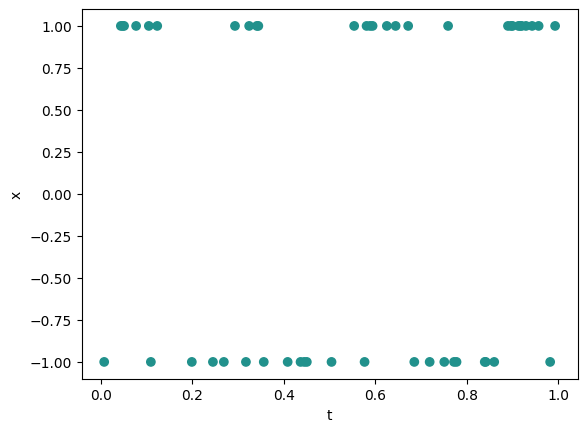

In [ ]:
pl.scatter(t_b, x_b, c=u_b, marker='o', clim=(-1,1))
pl.xlabel("t")
pl.ylabel("x");

# get points inside the space at random where the function will be predicted

In [ ]:
t_r = tf.random.uniform((n_r, 1), tmin, tmax, dtype="float32")
x_r = tf.random.uniform((n_r, 1), xmin, xmax, dtype="float32")
X_r = tf.concat([t_r, x_r], axis=1)
X_r

<tf.Tensor: shape=(10000, 2), dtype=float32, numpy=
array([[ 0.48962688, -0.15719008],
       [ 0.5857923 ,  0.16138387],
       [ 0.36451697, -0.43461084],
       ...,
       [ 0.9338294 ,  0.9995079 ],
       [ 0.11166203, -0.28287673],
       [ 0.00506091,  0.7726338 ]], dtype=float32)>

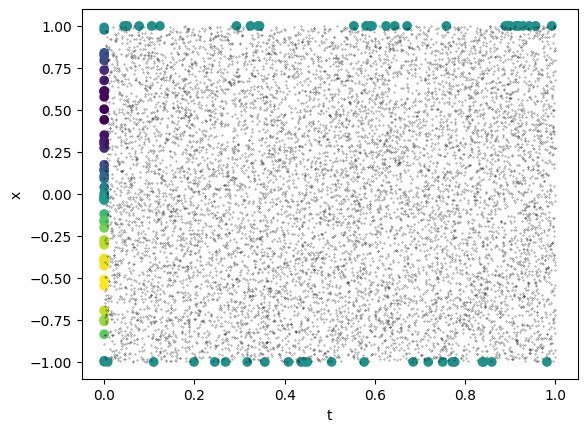

In [ ]:
pl.scatter(t_0, x_0, c=u_0, marker='o', clim=(-1,1))
pl.scatter(t_b, x_b, c=u_b, marker='o', clim=(-1,1))
pl.scatter(t_r, x_r, c="k", marker='.', s=0.3, alpha=0.7, clim=(-1,1))
pl.xlabel("t")
pl.ylabel("x");

In [ ]:
#put boundary conditionns together
X = tf.concat([X_0, X_b], axis=0) 
y = tf.concat([u_0, u_b], axis=0)
X.shape, y.shape


(TensorShape([100, 2]), TensorShape([100, 1]))

# create the model with simple loss

In [ ]:
nnmodel = tf.keras.Sequential()

#input layer with 2 neurons for 2 dimensions
nnmodel.add(tf.keras.Input(2))

#hidden layers
for i in range(8):
  nnmodel.add(tf.keras.layers.Dense(20, activation="tanh"))

#output layer is 1D
nnmodel.add(tf.keras.layers.Dense(1))


In [ ]:
optim = tf.keras.optimizers.Adam(learning_rate=0.001)
def custom_loss(u_pred, u_data):
  return tf.reduce_mean(tf.square(u_data - u_pred)) #L2

In [ ]:
nnmodel.compile(loss=custom_loss, optimizer=optim)

## train the model

In [ ]:
history = nnmodel.fit(X, y, epochs=1000)

Epoch 1/1000
4/4 [==============================] - 7s 10ms/step - loss: 0.4015
Epoch 2/1000
4/4 [==============================] - 0s 7ms/step - loss: 0.1946
Epoch 3/1000
4/4 [==============================] - 0s 7ms/step - loss: 0.2328
Epoch 4/1000
4/4 [==============================] - 0s 7ms/step - loss: 0.2116
Epoch 5/1000
4/4 [==============================] - 0s 7ms/step - loss: 0.1794
Epoch 6/1000
4/4 [==============================] - 0s 7ms/step - loss: 0.1805
Epoch 7/1000
4/4 [==============================] - 0s 8ms/step - loss: 0.1826
Epoch 8/1000
4/4 [==============================] - 0s 7ms/step - loss: 0.1746
Epoch 9/1000
4/4 [==============================] - 0s 7ms/step - loss: 0.1723
Epoch 10/1000
4/4 [==============================] - 0s 7ms/step - loss: 0.1798
Epoch 11/1000
4/4 [==============================] - 0s 7ms/step - loss: 0.1698
Epoch 12/1000
4/4 [==============================] - 0s 7ms/step - loss: 0.1579
Epoch 13/1000
4/4 [=============================

Text(0, 0.5, 'loss')

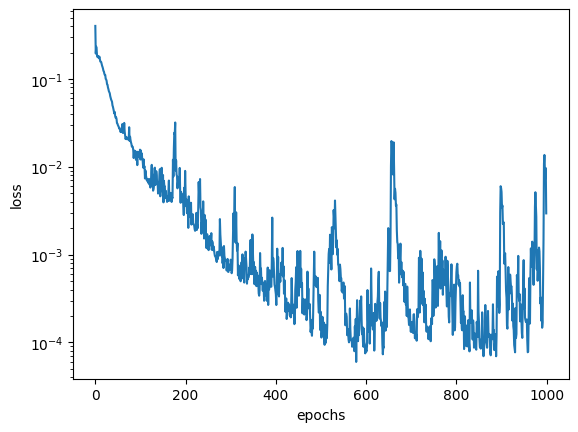

In [ ]:
pl.semilogy(history.history["loss"])
pl.xlabel("epochs")
pl.ylabel("loss")

## see the result

In [ ]:
nnmodel.predict(tf.concat([t_r, x_r], axis=1))

313/313 [==============================] - 1s 3ms/step


array([[-9.9773593e-03],
       [-2.1674158e-04],
       [-3.4520817e-03],
       ...,
       [ 3.0680340e-02],
       [ 2.0795147e-01],
       [-8.1977695e-01]], dtype=float32)

313/313 [==============================] - 1s 3ms/step


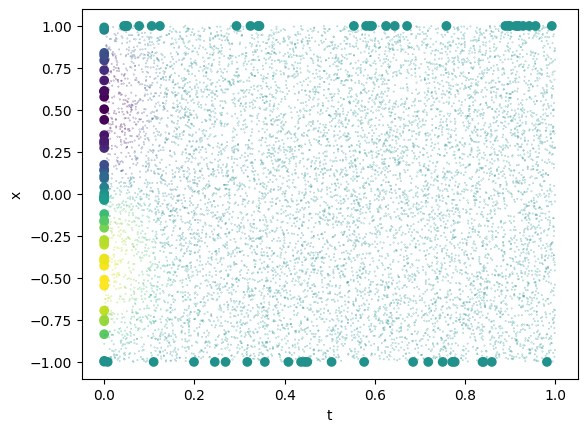

In [ ]:
pl.scatter(t_0, x_0, c=u_0, marker='o', clim=(-1,1))
pl.scatter(t_b, x_b, c=u_b, marker='o', clim=(-1,1))
pl.scatter(t_r, x_r, c=nnmodel.predict(tf.concat([t_r, x_r], axis=1)), marker='.', 
           s=0.2, alpha=0.7, clim=(-1,1))
pl.xlabel("t")
pl.ylabel("x");

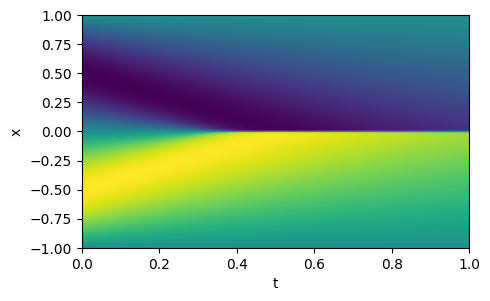

In [ ]:
ax = pl.figure(figsize=(5,5)).add_subplot(111)
cb = ax.imshow(Z[::-1],extent=[0,1,-1,1], clim=(-1,1))
ax.set_xlabel("t")
ax.set_ylabel("x");
ax.set_aspect(0.3);


show the accuracy for every point that you solved for

8/8 [==============================] - 0s 2ms/step


-0.463914217469449

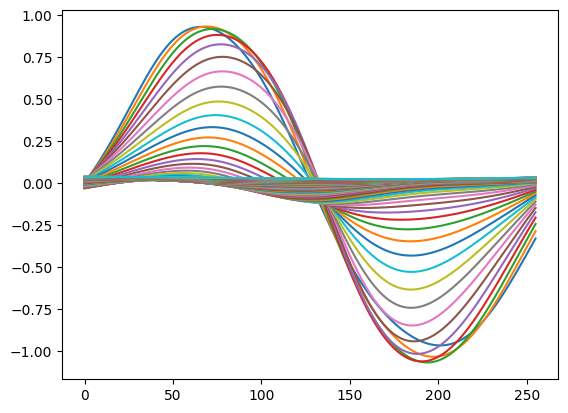

In [ ]:
def L1accuracy(t, x, model):
  tmp_ = np.zeros((x.shape[0], 2), dtype="float32") 
  tmp_[:,1] += x
  acc = 0
  for tt in range(t.shape[0]):
    tmp_[:,0] = t[tt]
    pl.plot(model.predict(tmp_))
    acc += (model.predict(tmp_) - Z[:,tt]).sum()
    

  return acc / np.prod(t.shape[0] * x.shape[0])
L1accuracy(t, x, nnmodel)

8/8 [==============================] - 0s 5ms/step


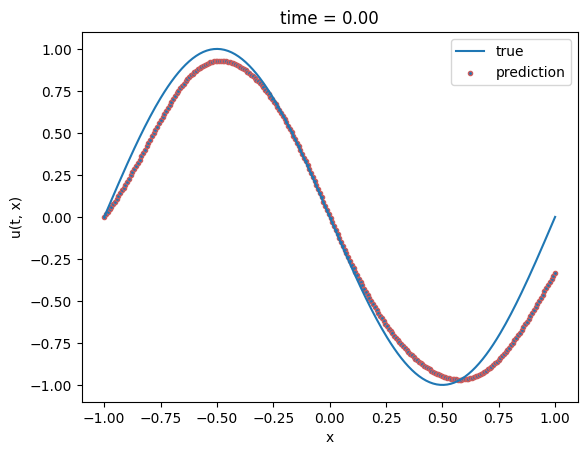

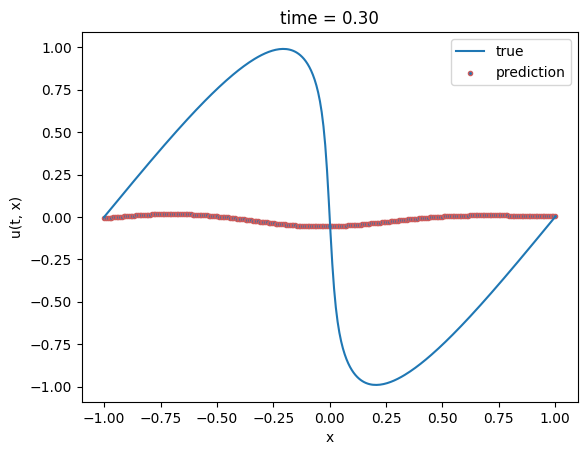

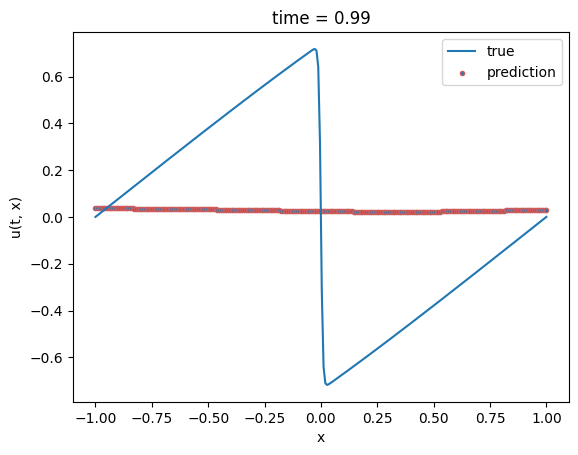

In [ ]:
tmp_ = np.zeros((x.shape[0], 2), dtype="float32") 
tmp_[:,1] += x
inds = [0, 30, -1]
for i in range(3):
  pl.figure()
  pl.title("time = %.2f"%t[inds[i]])
  pl.plot(x, Z[:,inds[i]], label="true")
  tmp_[:,0] = t[inds[i]]
  pl.scatter(x, nnmodel.predict(tmp_), marker='.', edgecolors="IndianRed",
             label="prediction")
  pl.xlabel("x")
  pl.ylabel("u(t, x)")
  pl.legend();


# create the model with complete loss

In [ ]:
def get_pde(model, X_r):

  with tf.GradientTape(persistent=True) as tape:
      t, x = X_r[:,0:1], X_r[:,1:2]
      tape.watch(t)
      tape.watch(x)
      u = model(tf.concat([t, x], axis=1))
      u_x = tape.gradient(u,x)
      #print(u_x)
  u_t = tape.gradient(u, t)
  u_xx = tape.gradient(u_x, x)

  del tape # to save some memory

  return u, u_t, u_x, u_xx 


In [ ]:
def custom_loss(model, X_r, X, y):
  u_pred = model(X)
  loss = tf.reduce_mean(tf.square(y - u_pred)) #MSE
  # now the PDE component of the loss
  u_pred, u_t, u_x, u_xx = get_pde(model, X_r) 
  resids = fun_res(u_pred, u_t, u_x, u_xx) #PDE
  loss += tf.reduce_mean(tf.square(resids)) #MSPDE
  return loss


In [ ]:
def get_grad(model, X_r, X, y):
    # model derivatives for backprop
    with tf.GradientTape(persistent=True) as tape:
        tape.watch(model.trainable_variables)
        loss = custom_loss(model, X_r, X, y)

    g = tape.gradient(loss, model.trainable_variables)
    del tape

    return loss, g

## train the model

In [ ]:
import copy

In [ ]:
pinn = tf.keras.Sequential()

#input layer with 2 neurons for 2 dimensions
pinn.add(tf.keras.Input(2))

#hidden layers
for i in range(8):
  pinn.add(tf.keras.layers.Dense(20, activation="tanh"))

#output layer is 1D
pinn.add(tf.keras.layers.Dense(1))

In [ ]:
@tf.function
def train_step(model, X_r, X, y):
  
  loss, grad = get_grad(model, X_r, X, y)
  optim.apply_gradients(zip(grad, model.trainable_variables))
  return loss

optim = tf.keras.optimizers.Adam(learning_rate=0.005)
pinn.compile(loss=custom_loss, optimizer=optim) #change the loss and optimization

history = []
Nepochs = 5000
for i in range(Nepochs):
  loss = train_step(pinn, X_r, X, y)
  history.append(loss.numpy())
  # Output current loss after 50 iterates
  if i%50 == 0:
        print('It {:05d}: loss = {:10.8e}'.format(i,loss))
        


It 00000: loss = 6.16375983e-01
It 00050: loss = 1.21152118e-01
It 00100: loss = 8.36742893e-02
It 00150: loss = 8.99944976e-02
It 00200: loss = 6.04008436e-02
It 00250: loss = 6.72768131e-02
It 00300: loss = 4.69007902e-02
It 00350: loss = 8.68696570e-02
It 00400: loss = 4.95952368e-02
It 00450: loss = 3.85608785e-02
It 00500: loss = 3.43384258e-02
It 00550: loss = 2.29545813e-02
It 00600: loss = 2.48882212e-02
It 00650: loss = 1.54175222e-01
It 00700: loss = 4.60907742e-02
It 00750: loss = 2.00565867e-02
It 00800: loss = 1.35315545e-02
It 00850: loss = 8.28269497e-03
It 00900: loss = 8.66045058e-03
It 00950: loss = 7.42485793e-03
It 01000: loss = 9.35853366e-03
It 01050: loss = 2.12535132e-02
It 01100: loss = 3.83654237e-03
It 01150: loss = 5.98377269e-03
It 01200: loss = 2.22535012e-03
It 01250: loss = 2.56190216e-03
It 01300: loss = 1.94259686e-03
It 01350: loss = 8.25142022e-03
It 01400: loss = 2.13536923e-03
It 01450: loss = 1.15182437e-03
It 01500: loss = 1.53202098e-02
It 01550

313/313 [==============================] - 1s 3ms/step


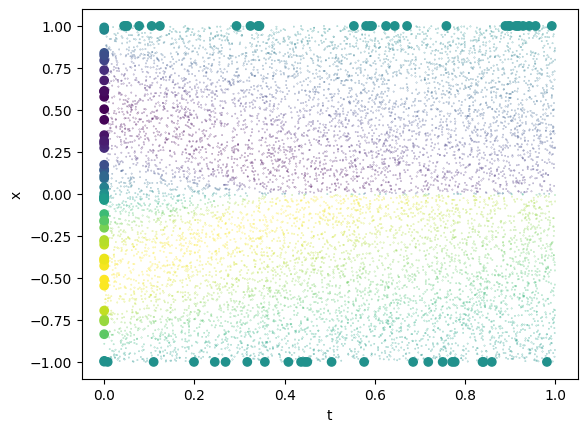

In [ ]:
pl.scatter(t_0, x_0, c=u_0, marker='o', clim=(-1,1))
pl.scatter(t_b, x_b, c=u_b, marker='o', clim=(-1,1))
pl.scatter(t_r, x_r, c=pinn.predict(tf.concat([t_r, x_r], axis=1)), marker='.', 
           s=0.2, alpha=0.7, clim=(-1,1))
pl.xlabel("t")
pl.ylabel("x");

313/313 [==============================] - 1s 4ms/step


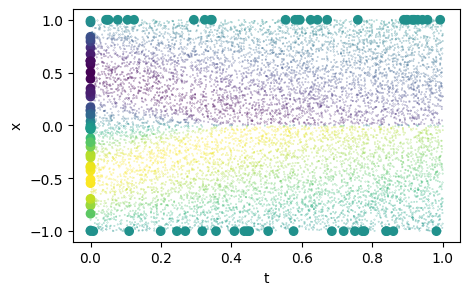

In [ ]:
ax = pl.figure(figsize=(5,5)).add_subplot(111)
ax.set_xlabel("t")
ax.set_ylabel("x");
ax.scatter(t_0, x_0, c=u_0, marker='o', clim=(-1,1))
ax.scatter(t_b, x_b, c=u_b, marker='o', clim=(-1,1))
ax.scatter(t_r, x_r, c=pinn.predict(tf.concat([t_r, x_r], axis=1)), 
           marker='.', s=0.2, alpha=0.7, clim=(-1,1))
pl.xlabel("t")
pl.ylabel("x");
ax.set_aspect(0.3);

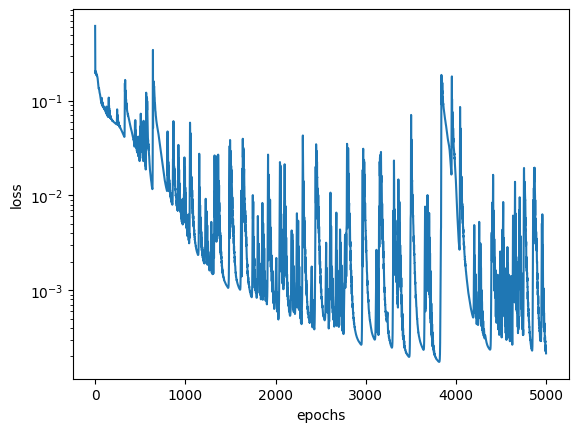

In [ ]:
pl.semilogy(history)
pl.xlabel("epochs")
pl.ylabel("loss");

8/8 [==============================] - 0s 2ms/step


0.16320419443754716

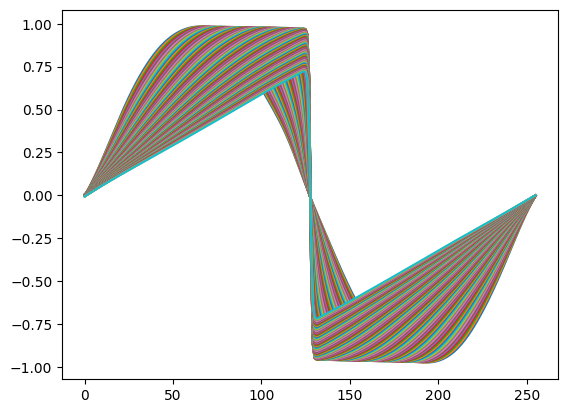

In [ ]:
L1accuracy(t, x, pinn)

In [ ]:
from tensorflow.keras.backend import set_value
set_value(pinn.optimizer.lr, 0.0001)

In [ ]:
Nepochs = 10000
for i in range(Nepochs):
  loss = train_step(pinn, X_r, X, y)
  history.append(loss.numpy())
  # Output current loss after 50 iterates
  if i%50 == 0:
        print('It {:05d}: loss = {:10.8e}'.format(i,loss))


It 00000: loss = 2.00652139e-04
It 00050: loss = 1.89908300e-04
It 00100: loss = 1.87897807e-04
It 00150: loss = 1.86267804e-04
It 00200: loss = 1.84767821e-04
It 00250: loss = 1.83350159e-04
It 00300: loss = 1.81989657e-04
It 00350: loss = 1.80674600e-04
It 00400: loss = 1.79396884e-04
It 00450: loss = 1.78152637e-04
It 00500: loss = 1.76934758e-04
It 00550: loss = 1.75746361e-04
It 00600: loss = 1.74582165e-04
It 00650: loss = 1.73441847e-04
It 00700: loss = 1.72323853e-04
It 00750: loss = 1.71228312e-04
It 00800: loss = 1.70154293e-04
It 00850: loss = 1.69100356e-04
It 00900: loss = 1.68066967e-04
It 00950: loss = 1.67052174e-04
It 01000: loss = 1.66054073e-04
It 01050: loss = 1.65074322e-04
It 01100: loss = 1.64110053e-04
It 01150: loss = 1.63161254e-04
It 01200: loss = 1.62226308e-04
It 01250: loss = 1.61304008e-04
It 01300: loss = 1.60395866e-04
It 01350: loss = 1.59496354e-04
It 01400: loss = 1.58608265e-04
It 01450: loss = 1.57729839e-04
It 01500: loss = 1.56857626e-04
It 01550

Text(0, 0.5, 'loss')

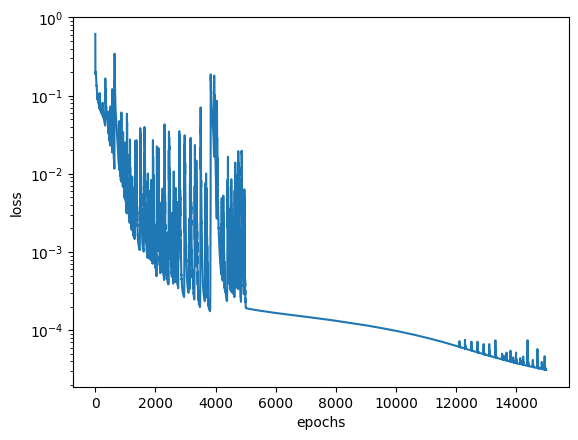

In [ ]:
pl.semilogy(history)
pl.xlabel("epochs")
pl.ylabel("loss")

313/313 [==============================] - 1s 3ms/step


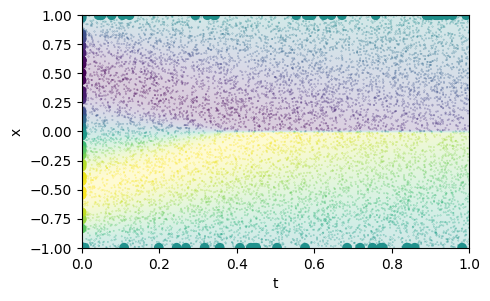

In [ ]:
ax = pl.figure(figsize=(5,5)).add_subplot()
ax.imshow(Z[::-1],extent=[0,1,-1,1], alpha=0.2)
ax.scatter(t_0, x_0, c=u_0, marker='o', clim=(-1,1))
ax.scatter(t_b, x_b, c=u_b, marker='o', clim=(-1,1))
ax.scatter(t_r, x_r, c=pinn.predict(tf.concat([t_r, x_r], axis=1)), 
           marker='.', s=0.2, alpha=0.7, clim=(-1,1))
ax.set_xlabel("t")
ax.set_ylabel("x");
ax.set_aspect(0.3);

In [ ]:
Nepochs = 10000
for i in range(Nepochs):
  loss = train_step(pinn, X_r, X, y)
  history.append(loss.numpy())
  # Output current loss after 50 iterates
  if i%50 == 0:
        print('It {:05d}: loss = {:10.8e}'.format(i,loss))

It 00000: loss = 3.10487776e-05
It 00050: loss = 3.07014197e-05
It 00100: loss = 3.20687468e-05
It 00150: loss = 3.02775279e-05
It 00200: loss = 2.98794293e-05
It 00250: loss = 2.98195991e-05
It 00300: loss = 2.93770117e-05
It 00350: loss = 2.91063388e-05
It 00400: loss = 3.84647428e-05
It 00450: loss = 2.87137464e-05
It 00500: loss = 2.83660447e-05
It 00550: loss = 2.81325756e-05
It 00600: loss = 2.79186443e-05
It 00650: loss = 2.79569340e-05
It 00700: loss = 2.74157392e-05
It 00750: loss = 2.94223646e-05
It 00800: loss = 2.69877200e-05
It 00850: loss = 2.67484356e-05
It 00900: loss = 2.72093348e-05
It 00950: loss = 2.67308715e-05
It 01000: loss = 2.61235273e-05
It 01050: loss = 2.59183071e-05
It 01100: loss = 2.57940137e-05
It 01150: loss = 2.55108025e-05
It 01200: loss = 2.53119397e-05
It 01250: loss = 2.60085617e-05
It 01300: loss = 2.86569284e-05
It 01350: loss = 2.47639273e-05
It 01400: loss = 2.83512163e-05
It 01450: loss = 2.43891882e-05
It 01500: loss = 2.41930720e-05
It 01550

Text(0, 0.5, 'loss')

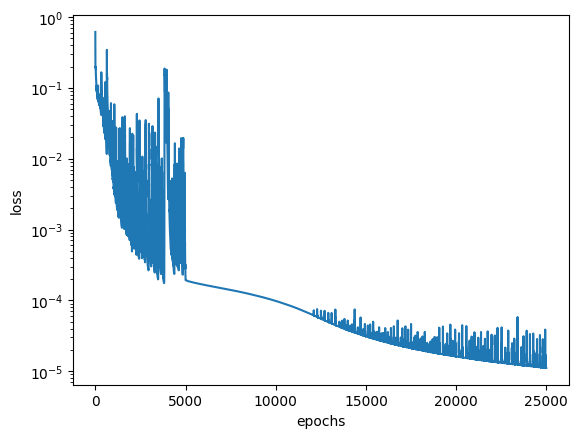

In [ ]:
pl.semilogy(history)
pl.xlabel("epochs")
pl.ylabel("loss")

## final result

8/8 [==============================] - 0s 2ms/step


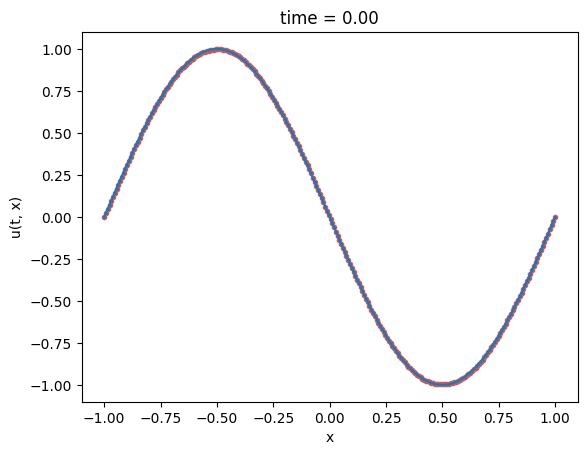

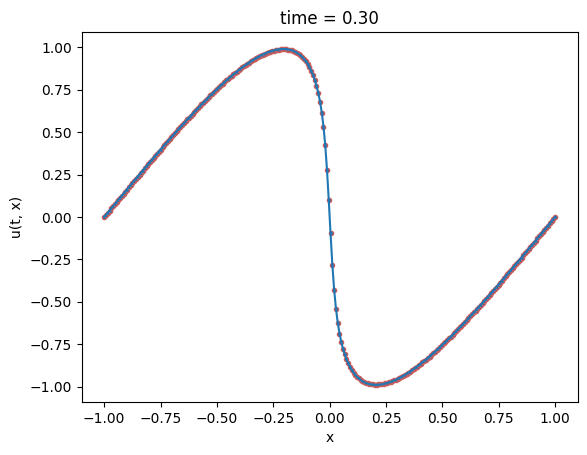

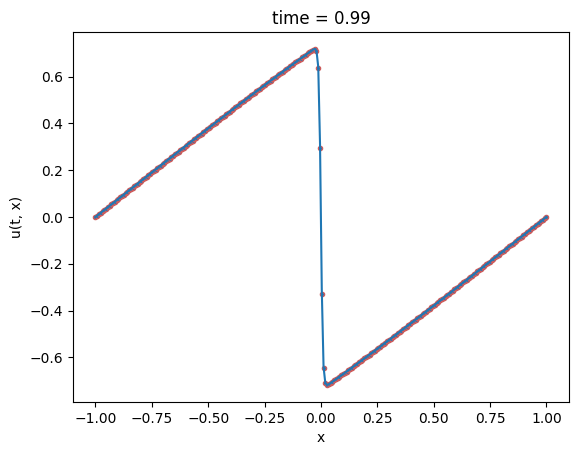

In [ ]:
for i in range(3):
  pl.figure()
  pl.title("time = %.2f"%t[inds[i]])
  pl.plot(x, Z[:,inds[i]])
  tmp_[:,0] = t[inds[i]]
  pl.scatter(x, pinn.predict(tmp_), marker='.', edgecolors="IndianRed")
  pl.xlabel("x")
  pl.ylabel("u(t, x)");

313/313 [==============================] - 1s 3ms/step


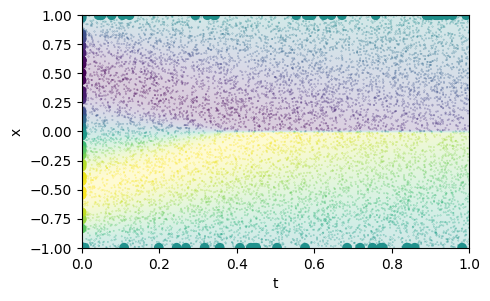

In [ ]:
ax = pl.figure(figsize=(5,5)).add_subplot(111)
ax.imshow(Z[::-1], extent=[0,1,-1,1], alpha=0.2)
ax.scatter(t_0, x_0, c=u_0, marker='o', clim=(-1,1))
ax.scatter(t_b, x_b, c=u_b, marker='o', clim=(-1,1))
ax.scatter(t_r, x_r, c=pinn.predict(tf.concat([t_r, x_r], axis=1)), 
           marker='.', s=0.2, alpha=0.7, clim=(-1,1))
ax.set_xlabel("t")
ax.set_ylabel("x");
ax.set_aspect(0.3)
#pl.colorbar();

8/8 [==============================] - 0s 2ms/step


-0.1476002366376828

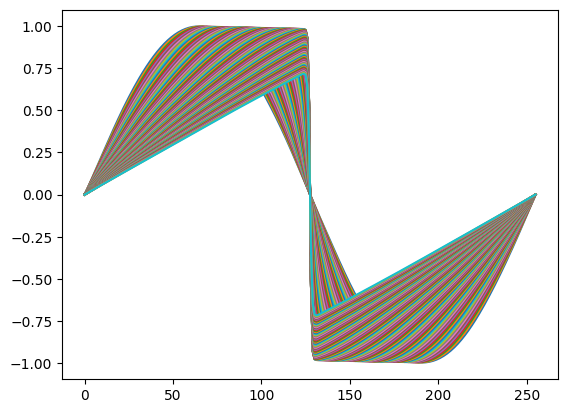

In [ ]:
L1accuracy(t, x, pinn)